In [1]:
import os

stream = os.popen('curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-images-idx3-ubyte.gz -o /tmp/train-images-idx3-ubyte.gz')
output = stream.read()
output

''

In [2]:
stream = os.popen('curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/train-labels-idx1-ubyte.gz -o /tmp/train-labels-idx1-ubyte.gz')
output = stream.read()
output

''

In [3]:
stream = os.popen('curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-images-idx3-ubyte.gz -o /tmp/t10k-images-idx3-ubyte.gz')
output = stream.read()
output

''

In [4]:
stream = os.popen('curl -fsS http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/t10k-labels-idx1-ubyte.gz -o /tmp/t10k-labels-idx1-ubyte.gz')
output = stream.read()
output

''

In [5]:
import os
import gzip
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import OrderedDict

In [6]:
def load_mnist(path, kind='train'):


    """Load MNIST data from `path`"""
    labels_path = os.path.join(path,
                               '/tmp/%s-labels-idx1-ubyte.gz'
                               % kind)
    images_path = os.path.join(path,
                               '/tmp/%s-images-idx3-ubyte.gz'
                               % kind)

    with gzip.open(labels_path, 'rb') as lbpath:
        labels = np.frombuffer(lbpath.read(), dtype=np.uint8,
                               offset=8)

    with gzip.open(images_path, 'rb') as imgpath:
        images = np.frombuffer(imgpath.read(), dtype=np.uint8,
                               offset=16).reshape(len(labels), 784)

    return images, labels

In [7]:
def _filter(xs, ys, lbls):
    idxs = [i for (i, l) in enumerate(ys) if l in lbls]
    return xs[idxs, :], ys[idxs]

In [8]:
def clear_gpu(model):
    # Removes model from gpu and clears the memory
    
    model = model.to('cpu')
    del model
    torch.cuda.empty_cache()

In [9]:
class Dataset(torch.utils.data.Dataset):
    # Basic dataset class to work with torch data loader

    def __init__(self, X, y):
        self.X = X
        self.y = y
        
        assert len(X) == len(y), print("Number of examples don't match up")

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]


In [10]:
from torch import nn

class Autoencoder(torch.nn.Module):
  
  def __init__(self, encoder_units, decoder_units, input_dim, output_dim):
    
    # Conventional super-class declaration
    super(Autoencoder, self).__init__()

    # Initialize lists to store layers
    encoder = []
    decoder = []

    # Add input and output dimensions to layer list for encoder
    self.encoder_units = [input_dim] + encoder_units
    self.decoder_units = [encoder_units[-1]] + decoder_units + [output_dim]

    # Compute the total no. of layers for the encoder/decoder
    self.encoder_layers = len(self.encoder_units)
    self.decoder_layers = len(self.decoder_units)

    # Append the hidden layers for the encoder
    for i in range(1, self.encoder_layers):
      
      # Add linear layer
      layer = ('Linear{}'.format(i), nn.Linear(self.encoder_units[i-1], self.encoder_units[i]))
      activation = ('RELU{}'.format(i), nn.ReLU(True))
      
      # Append
      encoder.append(layer)
      encoder.append(activation)
    
    # Append the hidden layers for the decoder
    for i in range(1, self.decoder_layers - 1):
      
      # Add the layers
      layer = ('Linear{}'.format(i), nn.Linear(self.decoder_units[i-1], self.decoder_units[i]))
      activation = ('RELU{}'.format(i), nn.ReLU(True))
      
      # Append to the lists
      decoder.append(layer)
      decoder.append(activation)

    # Create final output layer
    i = self.decoder_layers - 1
    layer = ('Linear{}'.format(i), nn.Linear(self.decoder_units[i-1], self.decoder_units[i]))
    activation = ('Sigmoid{}'.format(i), nn.Sigmoid())
    
    # Append to decoder list
    decoder.append(layer)
    decoder.append(activation)
    
    # Wrap this in a container and declare the encoder/decoder
    self.encoder = nn.Sequential(OrderedDict(encoder))
    self.decoder = nn.Sequential(OrderedDict(decoder))
    
  def forward(self, x):
    
    # First encode the noisy image and then decode
    x=self.encoder(x)
    x=self.decoder(x)
    
    return x
'''
class Autoencoder(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.encoder_hidden_layer = nn.Linear(
            in_features=kwargs["input_shape"], out_features=128
        )
        self.encoder_output_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_hidden_layer = nn.Linear(
            in_features=128, out_features=128
        )
        self.decoder_output_layer = nn.Linear(
            in_features=128, out_features=kwargs["input_shape"]
        )

    def forward(self, features):
        activation = self.encoder_hidden_layer(features)
        activation = torch.relu(activation)
        code = self.encoder_output_layer(activation)
        code = torch.relu(code)
        activation = self.decoder_hidden_layer(code)
        activation = torch.relu(activation)
        activation = self.decoder_output_layer(activation)
        reconstructed = torch.sigmoid(activation)
        return reconstructed

      '''

'\nclass Autoencoder(nn.Module):\n    def __init__(self, **kwargs):\n        super().__init__()\n        self.encoder_hidden_layer = nn.Linear(\n            in_features=kwargs["input_shape"], out_features=128\n        )\n        self.encoder_output_layer = nn.Linear(\n            in_features=128, out_features=128\n        )\n        self.decoder_hidden_layer = nn.Linear(\n            in_features=128, out_features=128\n        )\n        self.decoder_output_layer = nn.Linear(\n            in_features=128, out_features=kwargs["input_shape"]\n        )\n\n    def forward(self, features):\n        activation = self.encoder_hidden_layer(features)\n        activation = torch.relu(activation)\n        code = self.encoder_output_layer(activation)\n        code = torch.relu(code)\n        activation = self.decoder_hidden_layer(code)\n        activation = torch.relu(activation)\n        activation = self.decoder_output_layer(activation)\n        reconstructed = torch.sigmoid(activation)\n       

In [11]:
train_images, train_labels = load_mnist('data', 'train')
test_images, test_labels = load_mnist('data', 't10k')

In [12]:
dataloader_params = {'batch_size': 1024, 'shuffle': True, 'num_workers': 6}
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")



In [13]:
train_images, train_labels = load_mnist('data', 'train')
test_images, test_labels = load_mnist('data', 't10k')

val_images = train_images[50000:]
val_labels = train_labels[50000:]

train_images = train_images[:50000]
train_labels = train_labels[:50000]

In [35]:
#fashion mnist 1
X_train1, y_train1 = _filter(train_images, train_labels, [0, 1, 4, 5, 8])
X_val1, y_val1 = _filter(val_images, val_labels, [0, 1, 4, 5, 8])
X_test1, y_test1 = _filter(test_images, test_labels, [0, 1, 4, 5, 8])

In [15]:
#fashion mnist 2
X_train2, y_train2 = _filter(train_images, train_labels, [2, 3, 6, 7, 9])
X_val2, y_val2 = _filter(val_images, val_labels, [2, 3, 6, 7, 9])
X_test2, y_test2 = _filter(test_images, test_labels, [2, 3, 6, 7, 9])

In [16]:
#creating autoencoder train and validation set
x_train_autoenc = np.vstack((X_train1 ,X_train2 ,X_val2 ,X_test2))
x_train_autoenc = x_train_autoenc/255.0

y_train_autoenc = np.hstack((y_train1 ,y_train2 ,y_val2 ,y_test2))
x_val_autoenc = np.vstack((X_val1 , X_test1))
x_val_autoenc = x_val_autoenc/255.0
y_val_autoenc = np.hstack((y_val1 , y_test1))

In [17]:
train_data_auto_enc = Dataset(x_train_autoenc, y_train_autoenc)
train_generator_auto_enc = torch.utils.data.DataLoader(train_data_auto_enc, **dataloader_params)
val_data_auto_enc = Dataset(x_val_autoenc,y_val_autoenc)
val_generator_auto_enc = torch.utils.data.DataLoader(val_data_auto_enc, **dataloader_params)
'''
x_train_autoenc = torch.from_numpy(x_train_autoenc).type(torch.FloatTensor).to(device)
y_train_autoenc = torch.Tensor(y_train_autoenc).type(torch.LongTensor).to(device)

X_val_autoenc = torch.from_numpy(x_val_autoenc).type(torch.FloatTensor).to(device)
y_val_autoenc = torch.Tensor(y_val_autoenc).type(torch.LongTensor).to(device)
'''


'\nx_train_autoenc = torch.from_numpy(x_train_autoenc).type(torch.FloatTensor).to(device)\ny_train_autoenc = torch.Tensor(y_train_autoenc).type(torch.LongTensor).to(device)\n\nX_val_autoenc = torch.from_numpy(x_val_autoenc).type(torch.FloatTensor).to(device)\ny_val_autoenc = torch.Tensor(y_val_autoenc).type(torch.LongTensor).to(device)\n'

In [18]:

encoder_units = [256]
decoder_units = [256]
input_dim = 784
output_dim = 784
net = Autoencoder(encoder_units, decoder_units, input_dim, output_dim)
#net = Autoencoder(input_shape = 784)
net.to(device)

loss_fn = torch.nn.MSELoss()
#optimizer = torch.optim.Adam(net.parameters(),lr = 0.7)
optimizer = torch.optim.SGD(net.parameters(), lr=0.2,momentum = 0.9)

In [25]:
net.parameters()

<generator object Module.parameters at 0x7f72701c8eb8>

In [23]:
device

device(type='cuda', index=0)

In [19]:
#training routine for autoencoder
epochs = 40
for epoch in range(epochs):
  running_loss = 0.0
  val_loss = 0.0
  preds = []
  for i, data in enumerate(train_generator_auto_enc):
              
              # Get the inputs: data is a list of [inputs, labels]
              x, _ = data
              #print(x.shape)
              # Initialize container for noisy images
              #noisy_images = []

              # Now get noisy images
              
              

              # Send the inputs and labels to the memory of the device
              #noisy_images, flat_clean_imgs = noisy_images.to(device), flat_clean_imgs.to(device)

              # Zero the parameter gradients
              #x.to(device)
              x = x.type(torch.FloatTensor)
              x=x.to(device)
              optimizer.zero_grad()

              # Forward
              pred_x = net(x)
              preds.append((pred_x[0],x[0]))
              # Calculate loss
              #print(pred_x[0],x[0])
              loss = loss_fn(pred_x,x)

              # Backward
              loss.backward()
              
              # Optimize
              optimizer.step()

              # Add to running loss
              running_loss += loss.item()
  running_loss = (running_loss)/len(train_generator_auto_enc)
  
  for j,data in enumerate(val_generator_auto_enc):
    x_val , _  = data 
    with torch.no_grad():
      x_val = x_val.type(torch.FloatTensor)
      x_val = x_val.to(device)
      pred_x = net(x_val)
      loss = loss_fn(pred_x,x_val)
      val_loss+=loss.item()
  val_loss = val_loss/len(val_generator_auto_enc)
  print("epoch: ",epoch, "train_loss: ",running_loss,"val_loss:",val_loss)

epoch:  0 train_loss:  0.15552750242463612 val_loss: 0.1134523831307888
epoch:  1 train_loss:  0.09538349483982991 val_loss: 0.09492865055799485
epoch:  2 train_loss:  0.08914630064519785 val_loss: 0.08996298611164093
epoch:  3 train_loss:  0.07976031265521454 val_loss: 0.08001450225710868
epoch:  4 train_loss:  0.06960434365575596 val_loss: 0.07283783480525016
epoch:  5 train_loss:  0.0622909636694496 val_loss: 0.06485459506511689
epoch:  6 train_loss:  0.056523301149323836 val_loss: 0.06031922064721584
epoch:  7 train_loss:  0.05365908985673371 val_loss: 0.05795841105282307
epoch:  8 train_loss:  0.05170099670856686 val_loss: 0.05608433969318867
epoch:  9 train_loss:  0.049910834406392046 val_loss: 0.05433360785245896
epoch:  10 train_loss:  0.04811389302298174 val_loss: 0.052611615508794785
epoch:  11 train_loss:  0.04627082162236763 val_loss: 0.05089206248521805
epoch:  12 train_loss:  0.04441667714361417 val_loss: 0.04902545288205147
epoch:  13 train_loss:  0.04264274580498873 val

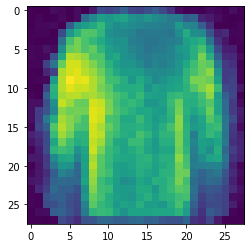

In [20]:
a,b = preds[-2]
a = a.cpu().detach().numpy()
b = b.cpu().detach().numpy()
plt.imshow(a.reshape(28,28))

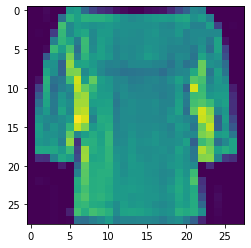

In [21]:
plt.imshow(b.reshape(28,28))

In [71]:
net.encoder.Linear1.weight

Parameter containing:
tensor([[ 2.5421e-02, -2.1288e-04,  6.1642e-02,  ..., -3.9452e-02,
         -7.3265e-02, -2.5514e-02],
        [ 2.5733e-02, -4.9902e-02, -6.8294e-02,  ..., -4.5370e-02,
         -7.7490e-02,  8.3840e-02],
        [ 1.0899e-02, -6.9107e-02, -8.0908e-02,  ..., -1.0650e-01,
         -5.5905e-02, -8.5170e-02],
        ...,
        [ 3.3303e-02, -4.5017e-01, -2.8376e-01,  ..., -1.4239e-01,
         -1.4423e-01,  3.4204e-02],
        [-2.7679e-02, -1.1544e-02,  2.1800e-02,  ..., -4.8923e-02,
         -2.1646e-02,  2.2567e-02],
        [ 9.2440e-04, -8.2279e-02, -6.2101e-02,  ..., -9.2137e-02,
         -7.1895e-02, -2.4563e-02]], device='cuda:0', requires_grad=True)

In [ ]:
# creating a mlp with autoencoder initialized weights
'''
class pretrained_mlp(torch.nn.Module):
  def __init__(self, encoder_layers,encoder_weights, mlp_hidden_layer, input_dim, output_dim,pretrained):
    super(pretrained_mlp, self).__init__()
    self.mlp_hidden_layer = mlp_hidden_layer
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.encoder_units = [input_dim] + encoder_layers
    self.encoder_layers = len(self.encoder_units)
    self.pretrained = pretrained
    encoder = []
    mlp = []
    # Append the hidden layers for the encoder
    for i in range(1, self.encoder_layers):
      
      # Add linear layer
      layer = nn.Linear(self.encoder_units[i-1], self.encoder_units[i])
      if pretrained :
        layer.weight = encoder_weights[i-1]
      layer = ('Linear{}'.format(i), layer)
      activation = ('RELU{}'.format(i), nn.ReLU(True))
      
      # Append
      encoder.append(layer)
      encoder.append(activation)
    self.mlp_units = [encoder_layers[-1]]+self.mlp_hidden_layer 
    self.mlp_layers = len(self.mlp_units)
    print("mlp_units: ",self.mlp_units)
    for i in range(1,self.mlp_layers):
      layer = ('Linear{}'.format(i), nn.Linear(self.mlp_units[i-1], self.mlp_units[i]))
      activation = ('RELU{}'.format(i), nn.ReLU(True))
      print("layer:",layer)
      mlp.append(layer)
      mlp.append(activation)
    output_layer =  ('Linear{}'.format(i+1), nn.Linear(self.mlp_units[-1],self.output_dim))
    activation = ('sigmoid{}'.format(i+1), nn.Sigmoid())
    mlp.append(output_layer)
    mlp.append(activation)
    self.encoder = nn.Sequential(OrderedDict(encoder))
    self.mlp = nn.Sequential(OrderedDict(mlp))

  def forward(self, x):
    
    # First encode the noisy image and then decode
    x=self.encoder(x)
    x=self.mlp(x)
    
    return x
'''

In [ ]:
#creating mlp  dataloaders for fashion mnist 1
'''
x_train_mlp = X_train1/255.0

y_train_mlp = y_train1
x_val_mlp = X_val1/255.0
y_val_mlp = y_val1 

train_data_mlp = Dataset(x_train_mlp, y_train_mlp)
train_loader_mlp = torch.utils.data.DataLoader(train_data_mlp, **dataloader_params)
val_data_mlp = Dataset(x_val_mlp, y_val_mlp)
val_loader_mlp = torch.utils.data.DataLoader(val_data_mlp, **dataloader_params)
'''

In [ ]:
y_val1

array([1, 0, 1, ..., 1, 0, 5], dtype=uint8)

In [ ]:
'''
encoder_units = [256]
mlp_units = [128,64]
input_dim = 784
output_dim = 10
encoder_weights = [net.encoder.Linear1.weight]
mlp_net = pretrained_mlp(encoder_units,encoder_weights, mlp_units, input_dim, output_dim,pretrained = True)
#net = Autoencoder(input_shape = 784)
mlp_net.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(),lr = 0.7)
optimizer = torch.optim.SGD(mlp_net.parameters(), lr=0.2,momentum = 0.9)
'''

mlp_units:  [256, 128, 64]
layer: ('Linear1', Linear(in_features=256, out_features=128, bias=True))
layer: ('Linear2', Linear(in_features=128, out_features=64, bias=True))


In [ ]:
mlp_net

pretrained_mlp(
  (encoder): Sequential(
    (Linear1): Linear(in_features=784, out_features=256, bias=True)
    (RELU1): ReLU(inplace=True)
  )
  (mlp): Sequential(
    (Linear1): Linear(in_features=256, out_features=128, bias=True)
    (RELU1): ReLU(inplace=True)
    (Linear2): Linear(in_features=128, out_features=64, bias=True)
    (RELU2): ReLU(inplace=True)
    (Linear3): Linear(in_features=64, out_features=10, bias=True)
    (sigmoid3): Sigmoid()
  )
)

In [22]:
class mlp_net (torch.nn.Module) :
  def __init__(self,input_dim,output_dim,hidden_dim,encoder_weight,pretrained):
    super(mlp_net, self).__init__()
    self.input_dim = input_dim
    self.output_dim = output_dim
    self.hidden_dim = hidden_dim
    self.layer1 = nn.Linear(self.input_dim, self.hidden_dim)
    self.activation1 = nn.ReLU()
    
    if pretrained ==True :
      self.layer1.weight = encoder_weight
    #print("mlp_layer weight: ",self.layer1.weight)
    self.layer2 = nn.Linear(self.hidden_dim, self.output_dim)
    self.activation2 = nn.Sigmoid()
  def forward(self,x):
    x = self.layer1(x)
    x = self.activation1(x)
    out = self.layer2(x)
    out = self.activation2(out)
    return out


In [65]:
mlp_net(input_dim,output_dim,hidden_dim,encoder_weight,pretrained = True)

mlp_layer weight:  Parameter containing:
tensor([[ 2.5421e-02, -2.1288e-04,  6.1642e-02,  ..., -3.9451e-02,
         -7.3265e-02, -2.5514e-02],
        [ 2.5733e-02, -4.9902e-02, -6.8295e-02,  ..., -4.5366e-02,
         -7.7489e-02,  8.3840e-02],
        [ 1.0899e-02, -6.9107e-02, -8.0908e-02,  ..., -1.0651e-01,
         -5.5908e-02, -8.5170e-02],
        ...,
        [ 3.3303e-02, -4.5017e-01, -2.8376e-01,  ..., -1.4239e-01,
         -1.4423e-01,  3.4204e-02],
        [-2.7679e-02, -1.1544e-02,  2.1800e-02,  ..., -4.8923e-02,
         -2.1646e-02,  2.2567e-02],
        [ 9.2440e-04, -8.2279e-02, -6.2101e-02,  ..., -9.2129e-02,
         -7.1888e-02, -2.4562e-02]], device='cuda:0', requires_grad=True)


mlp_net(
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (activation1): ReLU()
  (layer2): Linear(in_features=256, out_features=10, bias=True)
)

In [73]:
net.encoder.Linear1.weight

Parameter containing:
tensor([[ 2.5421e-02, -2.1288e-04,  6.1642e-02,  ..., -3.9452e-02,
         -7.3265e-02, -2.5514e-02],
        [ 2.5733e-02, -4.9902e-02, -6.8294e-02,  ..., -4.5370e-02,
         -7.7490e-02,  8.3840e-02],
        [ 1.0899e-02, -6.9107e-02, -8.0908e-02,  ..., -1.0650e-01,
         -5.5905e-02, -8.5170e-02],
        ...,
        [ 3.3303e-02, -4.5017e-01, -2.8376e-01,  ..., -1.4239e-01,
         -1.4423e-01,  3.4204e-02],
        [-2.7679e-02, -1.1544e-02,  2.1800e-02,  ..., -4.8923e-02,
         -2.1646e-02,  2.2567e-02],
        [ 9.2440e-04, -8.2279e-02, -6.2101e-02,  ..., -9.2137e-02,
         -7.1895e-02, -2.4563e-02]], device='cuda:0', requires_grad=True)

In [37]:
input_dim = 784
output_dim = 10
hidden_dim = 256
encoder_weight = net.encoder.Linear1.weight
#encoder_weight = 0
'''
mlp_net2 = mlp_net(input_dim,output_dim,hidden_dim,encoder_weight,pretrained = True)
#net = Autoencoder(input_shape = 784)
mlp_net2.to(device)

loss_fn = torch.nn.CrossEntropyLoss()
#optimizer = torch.optim.Adam(net.parameters(),lr = 0.7)
optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=0.01)
'''

'\nmlp_net2 = mlp_net(input_dim,output_dim,hidden_dim,encoder_weight,pretrained = True)\n#net = Autoencoder(input_shape = 784)\nmlp_net2.to(device)\n\nloss_fn = torch.nn.CrossEntropyLoss()\n#optimizer = torch.optim.Adam(net.parameters(),lr = 0.7)\noptimizer = torch.optim.Adam(mlp_net2.parameters(), lr=0.01)\n'

In [26]:
import random
#taking on 5% of data for training





In [24]:

def relabel_data(y):
  for i in range(len(y)):
    if y[i]==5 :
      y[i] = 2
    if y[i]==8 :
      y[i] = 3
  return y 

In [36]:
y_train1

array([0, 0, 0, ..., 5, 5, 1], dtype=uint8)

In [38]:

#net = Autoencoder(input_shape = 784)
pretrained = False
data_percent_list = [0.05,0.1,0.2,0.4,0.6,0.8]
data_percent = 0.8
test_acc_true = []
val_acc_true = []
x_train_mlp = X_train1
y_train_mlp = y_train1
x_val_mlp = X_val1
y_val_mlp = y_val1 
#temp = list(zip(x_train_mlp, y_train_mlp)) 
#random.shuffle(temp) 
x_train_mlp, y_train_mlp = zip(*temp)
size = len(x_train_mlp)
#for data_percent in data_percent_list :

#optimizer = torch.optim.Adam(net.parameters(),lr = 0.7)
val_data_mlp = Dataset(x_val_mlp, y_val_mlp)
val_loader_mlp = torch.utils.data.DataLoader(val_data_mlp, **dataloader_params)
test_data_mlp = Dataset(X_test1, y_test1)
test_loader_mlp = torch.utils.data.DataLoader(test_data_mlp, **dataloader_params)

train_data_mlp = Dataset(x_train_mlp[0:int(data_percent*size)], y_train_mlp[0:int(data_percent*size)])
train_loader_mlp = torch.utils.data.DataLoader(train_data_mlp, **dataloader_params)  
val_acc,test_acc  = train_mlp(input_dim,output_dim,hidden_dim,encoder_weight,pretrained,train_loader_mlp,test_loader_mlp,val_loader_mlp,20)
val_acc_true.append(val_acc)
test_acc_true.append(test_acc)

epoch:  0 train_loss:  2.125314939022064
epoch:  0 test_loss:  2.518496561050415 acc:  0.20333986477395047
epoch:  1 train_loss:  2.1203976392745973
epoch:  1 test_loss:  2.518626165390015 acc:  0.20395902011571582
epoch:  2 train_loss:  2.1185805201530457
epoch:  2 test_loss:  2.5185225009918213 acc:  0.20347967404467168
epoch:  3 train_loss:  2.1201180815696716
epoch:  3 test_loss:  2.5182891368865965 acc:  0.20415874764531755
epoch:  4 train_loss:  2.1189998626708983
epoch:  4 test_loss:  2.5182891368865965 acc:  0.20393904736275564
epoch:  5 train_loss:  2.1208635568618774
epoch:  5 test_loss:  2.518133592605591 acc:  0.20377926533907428
epoch:  6 train_loss:  2.120164716243744
epoch:  6 test_loss:  2.5184446811676025 acc:  0.20399896562163616
epoch:  7 train_loss:  2.1202112674713134
epoch:  7 test_loss:  2.518133592605591 acc:  0.20377926533907428
epoch:  8 train_loss:  2.119931697845459
epoch:  8 test_loss:  2.5181854248046873 acc:  0.2037592925861141
epoch:  9 train_loss:  2.11

KeyboardInterrupt: ignored

In [43]:
set(y_train1)

{0, 1, 4, 5, 8}

In [42]:
print(val_acc_true , test_acc_true)

[[1.7810163736343383], [1.5451267957687378], [1.3903373241424561], [1.3137418985366822], [1.2803945779800414], [1.402147603034973]] [[1.8347511053085328], [1.5147045612335206], [1.3889920711517334], [1.3459396600723266], [1.255441164970398], [1.445418119430542]]


In [32]:
pretrained = False
val_acc_false = []
test_acc_false = []
for data_percent in data_percent_list :
  train_data_mlp = Dataset(x_train_mlp[0:int(data_percent*size)], y_train_mlp[0:int(data_percent*size)])
  train_loader_mlp = torch.utils.data.DataLoader(train_data_mlp, **dataloader_params)  
  val_acc,test_acc  = train_mlp(input_dim,output_dim,hidden_dim,encoder_weight,pretrained,train_loader_mlp,test_loader_mlp,val_loader_mlp,20)
  val_acc_false.append(val_acc)
  test_acc_false.append(test_acc)

epoch:  0 train_loss:  1.5916569232940674
epoch:  0 test_loss:  1.568542718887329 acc:  0.3853418914827772
epoch:  1 train_loss:  1.6107159852981567
epoch:  1 test_loss:  1.7049563646316528 acc:  0.19854577334499462
epoch:  2 train_loss:  1.6799439191818237
epoch:  2 test_loss:  1.7046711206436158 acc:  0.1977668359795479
epoch:  3 train_loss:  1.6851754784584045
epoch:  3 test_loss:  1.7043859720230103 acc:  0.19822620929763185
epoch:  4 train_loss:  1.7026141285896301
epoch:  4 test_loss:  1.7048526525497436 acc:  0.1982661548035522
epoch:  5 train_loss:  1.6921510100364685
epoch:  5 test_loss:  1.705578589439392 acc:  0.19802648176803012
epoch:  6 train_loss:  1.6869194507598877
epoch:  6 test_loss:  1.7046452283859252 acc:  0.19822620929763185
epoch:  7 train_loss:  1.7008703351020813
epoch:  7 test_loss:  1.704878568649292 acc:  0.19780678148546824
epoch:  8 train_loss:  1.6973824501037598
epoch:  8 test_loss:  1.7049045085906982 acc:  0.19842593682723358
epoch:  9 train_loss:  1.

KeyboardInterrupt: ignored

In [40]:
print(val_acc_false,test_acc_false)

[[5.792197608947754], [3.6840911388397215], [1.9142696142196656], [0.3417442739009857], [0.38419090360403063], [0.2452104151248932]] [[5.640351867675781], [3.0648836135864257], [1.793165683746338], [0.3250050783157349], [0.32778828144073485], [0.1633344456553459]]


In [32]:
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.01
    weight_decay: 0
)

[0.9709935011061948]

In [25]:
def train_mlp(input_dim,output_dim,hidden_dim,encoder_weight,pretrained,train_loader_mlp,test_loader_mlp,val_loader_mlp,epochs):
  
  mlp_net1 = mlp_net(input_dim,output_dim,hidden_dim,encoder_weight,pretrained)
  mlp_net1.to(device)
  final_test_acc = []
  final_val_acc = []
  optimizer = torch.optim.Adam(mlp_net1.parameters(), lr=0.01)
  loss_fn = torch.nn.CrossEntropyLoss()
  val_loss_list = []
  train_loss_list = []
  val_acc_list = []
  test_loss_list = []
  test_acc_list = []
  '''
  train_data_mlp = Dataset(x_train_mlp[0:int(partition_list[0]*size)], y_train_mlp[0:int(partition_list[0]*size)])
  train_loader_mlp = torch.utils.data.DataLoader(train_data_mlp, **dataloader_params)
  mlp_net2 = mlp_net(input_dim,output_dim,hidden_dim,encoder_weight,pretrained = True)

  mlp_net2.to(device)
  optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=0.01)
  '''
  for epoch in range(epochs):
    running_loss = 0.0
    val_loss = 0.0
    preds = []
    acc =0.0
    test_acc = 0.0
    test_loss = 0.0
    
    for i, data in enumerate(train_loader_mlp):
                
                # Get the inputs: data is a list of [inputs, labels]
                x, y = data
                #print(x.shape)
                # Initialize container for noisy images
                #noisy_images = []

                # Now get noisy images
                
                

                # Send the inputs and labels to the memory of the device
                #noisy_images, flat_clean_imgs = noisy_images.to(device), flat_clean_imgs.to(device)

                # Zero the parameter gradients
                #x.to(device)
                x = x.type(torch.FloatTensor)
                y = y.type(torch.LongTensor)
                x = x.to(device)
                y = y.to(device)
                optimizer.zero_grad()

                # Forward
                pred = mlp_net1.forward(x)
                
                # Calculate loss
                
                loss = loss_fn(pred,y)

                # Backward
                loss.backward()
                
                # Optimize
                optimizer.step()

                # Add to running loss
                running_loss += loss.item()
    running_loss = (running_loss)/len(train_loader_mlp)
    print("epoch: ",epoch, "train_loss: ",running_loss)
    for j, data in enumerate(val_loader_mlp): 
      x,y = data 
      with torch.no_grad():
        x = x.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)
        x = x.to(device)
        y = y.to(device)
        pred = mlp_net1.forward(x)
        loss = loss_fn(pred,y)
        pred = pred.argmax(axis =1)
        val_loss += loss.item()
        #print("pred: ",pred.shape,"y:",y.shape)
        acc+= np.sum(pred.cpu().numpy()==y.cpu().numpy())/len(pred.cpu().numpy())
    val_loss = val_loss/len(val_loader_mlp)
    acc = acc/len(val_loader_mlp)
    for k, data in enumerate(test_loader_mlp): 
      x,y = data 
      with torch.no_grad():
        x = x.type(torch.FloatTensor)
        y = y.type(torch.LongTensor)
        x = x.to(device)
        y = y.to(device)
        pred = mlp_net1.forward(x)
        loss = loss_fn(pred,y)
        pred = pred.argmax(axis =1)
        test_loss += loss.item()
        #print("pred: ",pred[0],"y:",y[0])
        test_acc+= np.sum(pred.cpu().numpy()==y.cpu().numpy())/len(pred.cpu().numpy())
    test_loss = test_loss/len(test_loader_mlp)
    test_acc = test_acc/len(test_loader_mlp)
    print("epoch: ",epoch, "test_loss: ",test_loss,"acc: ",acc)
    val_loss_list.append(val_loss)
    val_acc_list.append(acc)
    test_loss_list.append(test_loss)
    test_acc_list.append(test_acc)
  final_test_acc.append(test_loss_list[-1])
  final_val_acc.append(val_loss_list[-1])
  clear_gpu(mlp_net1)
  return final_val_acc, final_test_acc

In [54]:
len(x_train_mlp)

24975

In [ ]:
loss_fn

CrossEntropyLoss()

In [ ]:
Autoencoder

In [37]:
#training routine for pretrained mlp

epochs = 20
partition_list = [0.05,0.1]
final_test_acc = []
final_val_acc = []

val_loss_list = []
train_loss_list = []
val_acc_list = []
test_loss_list = []
test_acc_list = []
'''
train_data_mlp = Dataset(x_train_mlp[0:int(partition_list[0]*size)], y_train_mlp[0:int(partition_list[0]*size)])
train_loader_mlp = torch.utils.data.DataLoader(train_data_mlp, **dataloader_params)
mlp_net2 = mlp_net(input_dim,output_dim,hidden_dim,encoder_weight,pretrained = True)

mlp_net2.to(device)
optimizer = torch.optim.Adam(mlp_net2.parameters(), lr=0.01)
'''
for epoch in range(epochs):
  running_loss = 0.0
  val_loss = 0.0
  preds = []
  acc =0.0
  test_acc = 0.0
  test_loss = 0.0
  
  for i, data in enumerate(train_loader_mlp):
              
              # Get the inputs: data is a list of [inputs, labels]
              x, y = data
              #print(x.shape)
              # Initialize container for noisy images
              #noisy_images = []

              # Now get noisy images
              
              

              # Send the inputs and labels to the memory of the device
              #noisy_images, flat_clean_imgs = noisy_images.to(device), flat_clean_imgs.to(device)

              # Zero the parameter gradients
              #x.to(device)
              x = x.type(torch.FloatTensor)
              y = y.type(torch.LongTensor)
              x = x.to(device)
              y = y.to(device)
              optimizer.zero_grad()

              # Forward
              pred = mlp_net2.forward(x)
              
              # Calculate loss
              
              loss = loss_fn(pred,y)

              # Backward
              loss.backward()
              
              # Optimize
              optimizer.step()

              # Add to running loss
              running_loss += loss.item()
  running_loss = (running_loss)/len(train_loader_mlp)
  print("epoch: ",epoch, "train_loss: ",running_loss)
  for j, data in enumerate(val_loader_mlp): 
    x,y = data 
    with torch.no_grad():
      x = x.type(torch.FloatTensor)
      y = y.type(torch.LongTensor)
      x = x.to(device)
      y = y.to(device)
      pred = mlp_net2(x)
      loss = loss_fn(pred,y)
      pred = pred.argmax(axis =1)
      val_loss += loss.item()
      #print("pred: ",pred,"y:",y)
      acc+= np.sum(pred.cpu().numpy()==y.cpu().numpy())/len(pred.cpu().numpy())
  val_loss = val_loss/len(val_loader_mlp)
  acc = acc/len(val_loader_mlp)
  for k, data in enumerate(test_loader_mlp): 
    x,y = data 
    with torch.no_grad():
      x = x.type(torch.FloatTensor)
      y = y.type(torch.LongTensor)
      x = x.to(device)
      y = y.to(device)
      pred = mlp_net2(x)
      loss = loss_fn(pred,y)
      pred = pred.argmax(axis =1)
      test_loss += loss.item()
      #print("pred: ",pred,"y:",y)
      test_acc+= np.sum(pred.cpu().numpy()==y.cpu().numpy())/len(pred.cpu().numpy())
  test_loss = test_loss/len(test_loader_mlp)
  test_acc = test_acc/len(test_loader_mlp)
  print("epoch: ",epoch, "test_loss: ",test_loss,"acc: ",test_acc)
  val_loss_list.append(val_loss)
  val_acc_list.append(acc)
  test_loss_list.append(test_loss)
  test_acc_list.append(test_acc)
final_test_acc.append(test_loss[-1])
final_val_acc.append(val_loss[-1])



NameError: ignored

In [47]:
test_acc_list

[0.9425193584070797,
 0.9410208102876106,
 0.94852046460177,
 0.9391731194690266,
 0.9445640901548673,
 0.9438070381637168,
 0.9340949944690266,
 0.9499792588495575,
 0.9510854535398231,
 0.9555119607300885]

In [ ]:
def run_experiment_with_x_percent_data(x):
  x_train_mlp = X_train1
  y_train_mlp = y_train1
  x_val_mlp = X_val1
  y_val_mlp = y_val1 
  temp = list(zip(x_train_mlp, y_train_mlp)) 
  random.shuffle(temp) 
  x_train_mlp, y_train_mlp = zip(*temp)
  size = len(x_train_mlp)
  train_data_mlp = Dataset(x_train_mlp[0:int(*size)], y_train_mlp[0:int(0.05*size)])
  train_loader_mlp = torch.utils.data.DataLoader(train_data_mlp, **dataloader_params)
  val_data_mlp = Dataset(x_val_mlp, y_val_mlp)
  val_loader_mlp = torch.utils.data.DataLoader(val_data_mlp, **dataloader_params)

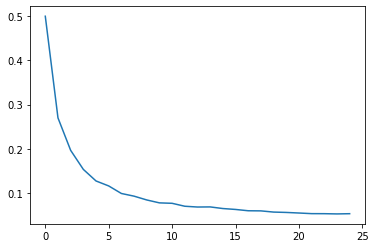

In [ ]:
plt.plot(train_loss_list)